#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импортируем библиотеки

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.metrics import make_scorer, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [ ]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверка, что индекс монотонный

In [ ]:
print(df.index.is_monotonic)

True


В нашем распоряжении данные с 1 марта 2018 по 31 августа 2018, пропусков нет, данные в хронологическом порядке.

`datetime` - дата и время заказа такси
`num_orders` - количество заказов (целевой признак)

## Анализ

Ресемплирование по одному часу

In [ ]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()


In [ ]:
print('Начальная дата:',df.index.min())
print('Конечная дата:',df.index.max())
print('Учтенное время:',df.index.max() - df.index.min())

Начальная дата: 2018-03-01 00:00:00
Конечная дата: 2018-08-31 23:00:00
Учтенное время: 183 days 23:00:00


In [ ]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [ ]:
df['num_orders'].sum()

372811

Мы имеем данные за 184 дня, 372811 заказов, минимальное количество заказов в час 0, максимальное 462.

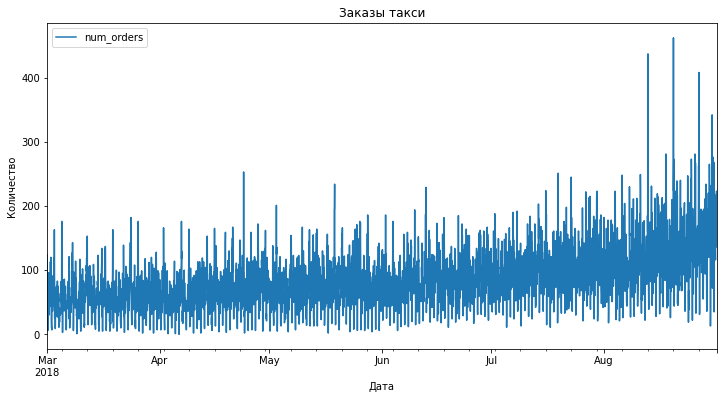

In [ ]:
df.plot(figsize=(12, 6))
plt.title('Заказы такси')
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.show()

Можно наблюдать тренд по графику выше

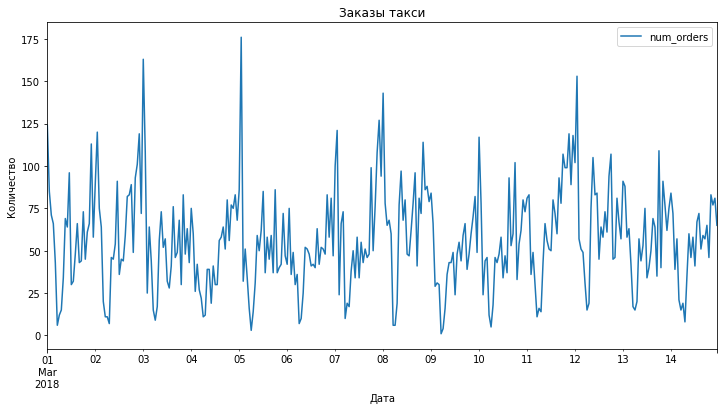

In [ ]:
df['2018-03-01':'2018-03-14'].plot(figsize=(12, 6))
plt.title('Заказы такси')
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.show()

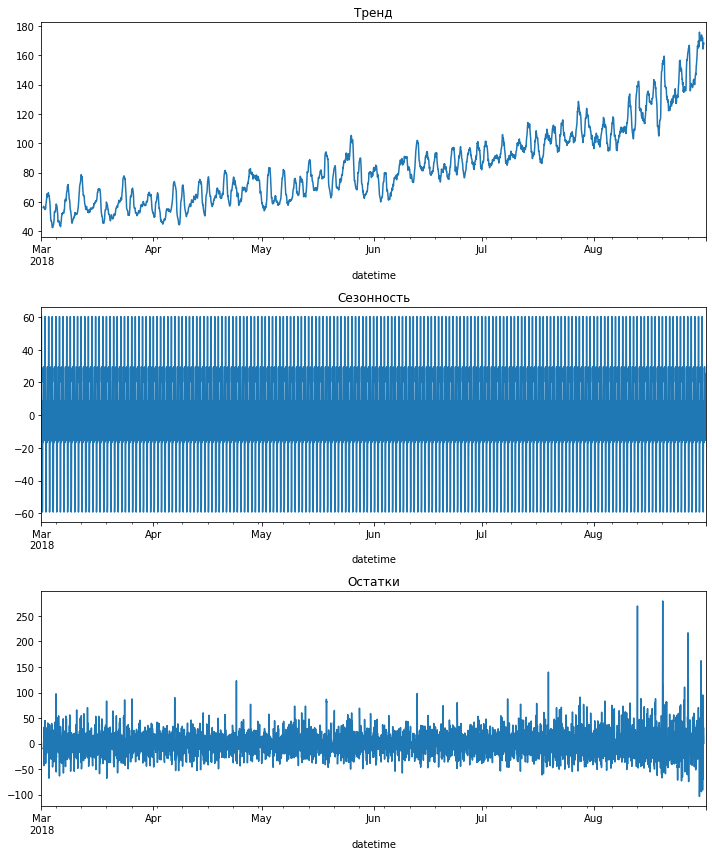

In [ ]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Опять же рассмотрим первые 2 недели

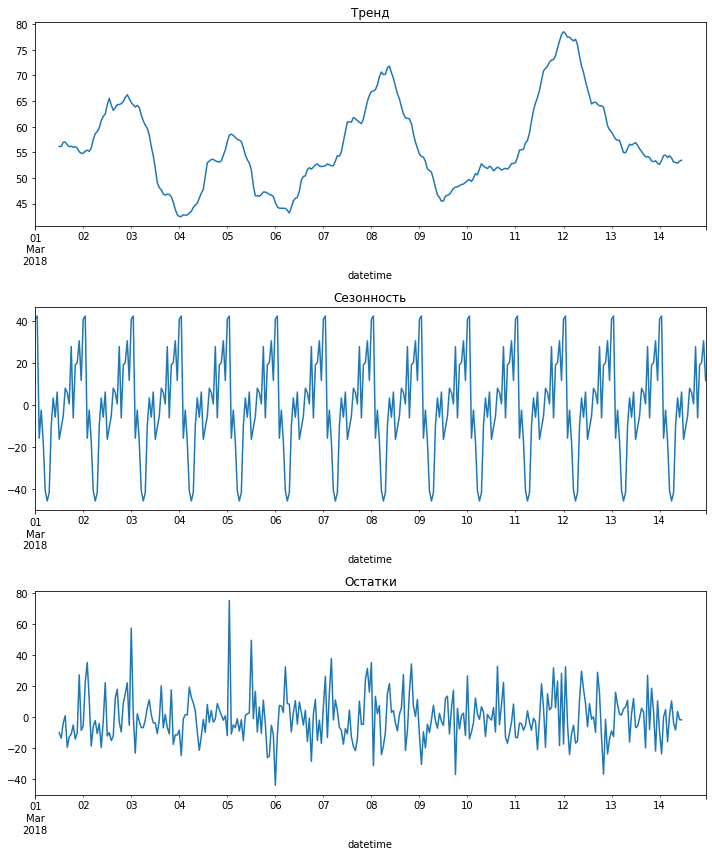

In [ ]:
decomposed_df = seasonal_decompose(df['2018-03-01':'2018-03-14'])
plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed_df.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed_df.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed_df.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Разности стационарного ряда

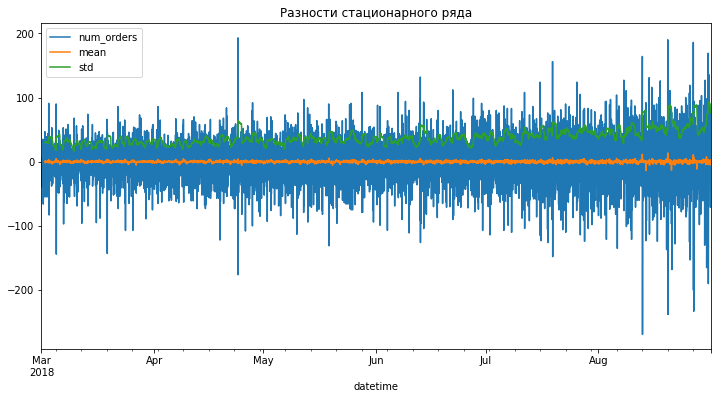

In [ ]:
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(24).mean()
df_shift['std'] = df_shift['num_orders'].rolling(24).std()
df_shift.plot(figsize=(12, 6))
plt.title('Разности стационарного ряда')
plt.show()

В данных имеетеся тренд к увеличению количества заказов (времянной ряд не стационарен), наблюдается суточная сезонность (вечерний час-пик, ночной спад).

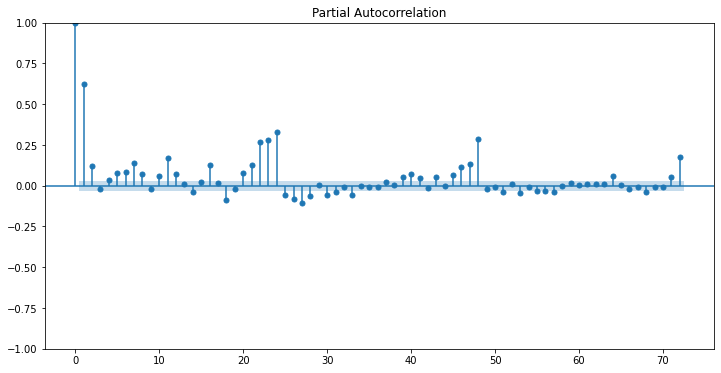

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df['num_orders'], ax=ax, lags=72, method='ywm')
plt.show()

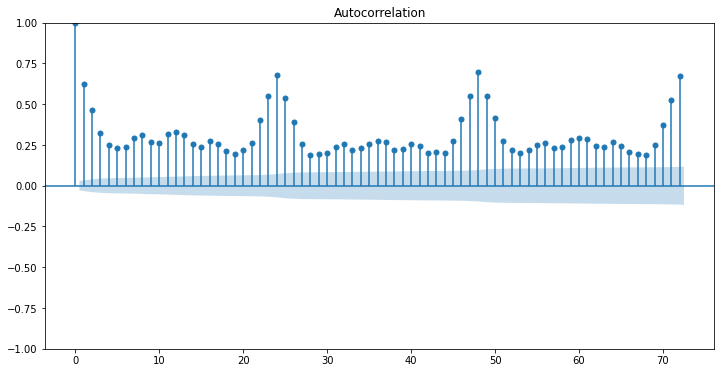

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['num_orders'], ax=ax, lags=72)
plt.show()

Результаты автокорреляционного исследования показывают, что существует значительная корреляция между количеством поездок в предыдущие часы, а также в предыдущие дни и количеством поездок в будущем. Это означает, что знание количества поездок в определенные периоды в прошлом может быть полезным для прогнозирования количества поездок в будущем.

## Обучение

### Добавление признаков, отстающие значения, скользящее среднее

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    #df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    data['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [ ]:
make_features(df, 168, 48)
df.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Разделение данных

In [ ]:
df = df.dropna()
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [ ]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (3823, 171)
Размер тестовой выборки: (425, 171)


Функция для показателей предсказаний моделей

In [ ]:
def illustration_target(test,predict):
    plt.figure(figsize=(8, 5))
    plt.plot(test.index, test, test.index, predict, alpha=0.5)
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий')
    plt.xticks(rotation=90)
    plt.show()

### Линейная регрессия

In [ ]:
#model_lr = LinearRegression()
#model_lr.fit(features_train, target_train)
#pred_model_lr = model_lr.predict(features_train)

#rmse_model_lr = (mean_squared_error(target_train, pred_model_lr)**0.5)

#print("RMSE Линейная регрессия:",rmse_model_lr)

Функция нахождения RMSE

In [ ]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5


RMSE_score = make_scorer(RMSE)

In [ ]:
my_cv = TimeSeriesSplit(n_splits=5).split(features_train)
regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression.fit(features_train, target_train)

regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()
print('Среднее RMSE на кросс-валидации:', regression_cv_score)

Среднее RMSE на кросс-валидации: 22.68127802430477


### CatBoost

In [ ]:
#model_cb = CatBoostRegressor(learning_rate=0.4,
#                             depth=5,
#                             random_state=12345,
#                             verbose=False)
#model_cb.fit(features_train, target_train)
#pred_model_cb = model_cb.predict(features_train)

#rmse_model_cb = RMSE(target_train, pred_model_cb)

#print("RMSE CatBoost:",rmse_model_cb)

In [ ]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
cat = CatBoostRegressor()
cat_parametrs = {'learning_rate': [0.1, 0.5],
                'depth': [4, 6, 8]}
cat_grid = GridSearchCV(cat, cat_parametrs, scoring=RMSE_score, cv=my_cv)
cat_grid.fit(features_train, target_train, verbose=100)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 28.3188536	total: 9.06ms	remaining: 9.05s
100:	learn: 13.0000237	total: 909ms	remaining: 8.09s
200:	learn: 9.4524120	total: 1.85s	remaining: 7.36s
300:	learn: 7.3243010	total: 2.72s	remaining: 6.32s
400:	learn: 5.5988640	total: 3.54s	remaining: 5.29s
500:	learn: 4.2126451	total: 4.42s	remaining: 4.4s
600:	learn: 3.2768443	total: 5.32s	remaining: 3.53s
700:	learn: 2.5358212	total: 6.22s	remaining: 2.65s
800:	learn: 1.9778517	total: 7.14s	remaining: 1.77s
900:	learn: 1.5378683	total: 7.96s	remaining: 874ms
999:	learn: 1.2209674	total: 8.82s	remaining: 0us
0:	learn: 31.5163393	total: 13.4ms	remaining: 13.4s
100:	learn: 15.3443582	total: 1.1s	remaining: 9.8s
200:	learn: 12.7823191	total: 2.23s	remaining: 8.86s
300:	learn: 10.9384356	total: 3.25s	remaining: 7.55s
400:	learn: 9.4225244	total: 4.34s	remaining: 6.49s
500:	learn: 8.1363925	total: 5.58s	remaining: 5.56s
600:	learn: 7.0269152	total: 6.66s	remaining: 4.42s
700:	learn: 6.1279329	total: 7.78s	remaining: 3.32s
800:	learn: 5

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f67a0f58ac0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f6798548f10>,
             param_grid={'depth': [4, 6, 8], 'learning_rate': [0.1, 0.5]},
             scoring=make_scorer(RMSE))

In [ ]:
cat_params = cat_grid.best_params_
cat_score = cat_grid.score(features_train, target_train)
print(cat_params)
print('RMSE CatBoost:',cat_score)

{'depth': 8, 'learning_rate': 0.5}
RMSE CatBoost: 9.262830584382089e-05


### Дерево решений

In [ ]:
my_cv = TimeSeriesSplit(n_splits=5).split(features_train)
tree = DecisionTreeRegressor()
tree_parametrs = {'max_depth': range(1, 20, 2),
                  'min_samples_leaf': range(2, 6, 2)}
tree_grid = GridSearchCV(tree, tree_parametrs, scoring=RMSE_score, cv=my_cv)
tree_grid.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f67a1a1c2e0>,
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 20, 2),
                         'min_samples_leaf': range(2, 6, 2)},
             scoring=make_scorer(RMSE))

In [ ]:
tree_params = tree_grid.best_params_
tree_score = tree_grid.score(features_train, target_train)
print(tree_params)
print('RMSE дерево решений:', tree_score)

{'max_depth': 15, 'min_samples_leaf': 2}
RMSE дерево решений: 7.182633132770422


In [ ]:
#model_dtr = DecisionTreeRegressor(criterion='mse',
#                              max_depth=10,
#                              random_state=12345)
#model_dtr.fit(features_train, target_train)
#pred_model_dtr = model_dtr.predict(features_train)

#rmse_model_dtr = RMSE(target_train, pred_model_dtr)

#print("RMSE  Дерево решений:", rmse_model_dtr)

RMSE  Дерево решений: 16.610401501110307


## Тестирование

In [ ]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse_c = RMSE(target_test, pred_previous)

print('RMSE константной модели:', rmse_c)

RMSE константной модели: 58.819724582830204


In [ ]:
regression_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

regression_RMSE = RMSE(target_test, regression_model_predictions)
print('RMSE Линейной регрессии:', regression_RMSE)

RMSE Линейной регрессии: 34.23163844940879


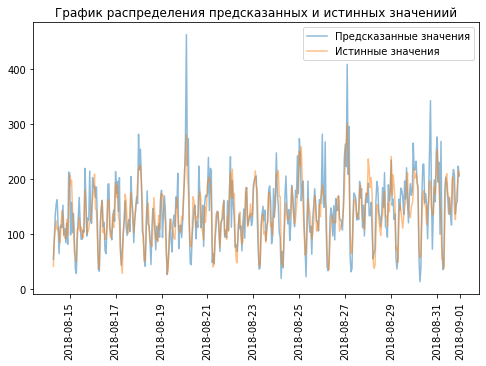

In [ ]:
illustration_target(target_test, regression_model_predictions)

In [ ]:
tree_model = DecisionTreeRegressor(random_state=12345,
                                     max_depth=tree_params['max_depth'],
                                     min_samples_leaf = tree_params['min_samples_leaf'])

tree_model.fit(features_train, target_train)
tree_model_predictions = tree_model.predict(features_test)

tree_RMSE = RMSE(target_test, tree_model_predictions)
print('RMSE Дерево решений:', tree_RMSE)

RMSE Дерево решений: 52.53299444603739


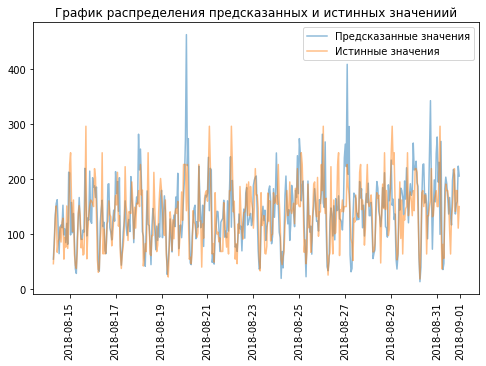

In [ ]:
illustration_target(target_test, tree_model_predictions)

In [ ]:
cat_model = CatBoostRegressor(learning_rate=cat_params['learning_rate'],
                                depth=cat_params['depth'])

cat_model.fit(features_train, target_train, verbose=100)
cat_model_predictions = cat_model.predict(features_test)

0:	learn: 29.4237104	total: 193ms	remaining: 3m 12s
100:	learn: 5.7574142	total: 12.2s	remaining: 1m 48s
200:	learn: 1.5481827	total: 24.3s	remaining: 1m 36s
300:	learn: 0.4594562	total: 36.4s	remaining: 1m 24s
400:	learn: 0.1273788	total: 48.4s	remaining: 1m 12s
500:	learn: 0.0393080	total: 1m	remaining: 1m
600:	learn: 0.0114914	total: 1m 12s	remaining: 48.2s
700:	learn: 0.0033453	total: 1m 25s	remaining: 36.3s
800:	learn: 0.0010587	total: 1m 37s	remaining: 24.2s
900:	learn: 0.0003007	total: 1m 49s	remaining: 12.1s
999:	learn: 0.0000926	total: 2m 2s	remaining: 0us


In [ ]:
cat_RMSE = RMSE(target_test, cat_model_predictions)
print('RMSE CatBoost:', cat_RMSE)

RMSE CatBoost: 41.99743981071181


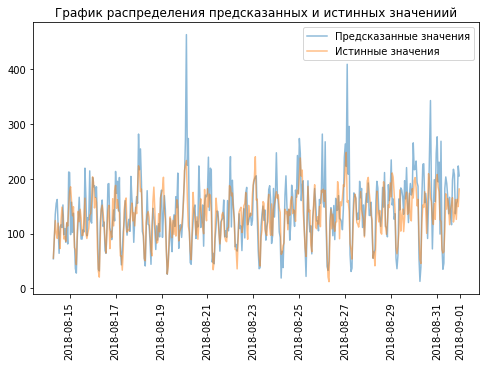

In [ ]:
illustration_target(target_test,cat_model_predictions)

In [ ]:
df = [[regression_RMSE],
     [tree_RMSE],
     [cat_RMSE],
     [rmse_c]]
model = ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'Сonstant model']
a = pd.DataFrame(data=df, index=model, columns=['RMSE'])
a.sort_values(by=['RMSE'])


,RMSE
LinearRegression,34.231638
CatBoostRegressor,41.997440
DecisionTreeRegressor,52.532994
Сonstant model,58.819725


Лучшее качество показала модель Линейной регрессии.

## Вывод

<div class="paragraph">Компания &laquo;Чётенькое такси&raquo; собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо было спрогнозировать количество заказов такси на следующий час.&nbsp;</div>
<div class="paragraph">Значение метрики <em>RMSE</em> на тестовой выборке должно было быть не больше 48.</div>
<div class="paragraph">&nbsp;</div>
<div class="paragraph">Данные были чистые, пропусков не было, данные были в хронологическом порядке.</div>
<div class="paragraph"><code>datetime</code>&nbsp;- дата и время заказа такси&nbsp;</div>
<div class="paragraph"><code>num_orders</code>&nbsp;- количество заказов (целевой признак)</div>
<div class="paragraph">&nbsp;</div>
<div class="paragraph">
<p>Начальная дата: 2018-03-01 00:00:00 Конечная дата: 2018-08-31 23:00:00 Учтенное время: 183 days 23:00:00<br /><br />В данных имелся тренд к увеличению количества заказов (времянной ряд не стационарен), наблюдалась суточная сезонность (вечерний час-пик, ночной спад).<br /><br />Обнаружена значительная корреляция между количеством поездок в предыдущие часы, а также в предыдущие дни и количеством поездок в будущем</p>
<p>В процессе обучения были добавлены признаки, отстающие значения, скользящее среднее.</p>
<p>Были обучены 3 модели:</p>
<p>Линейная регрессия</p>
<p>Дерево решений</p>
<p>CatBoost</p>
<p>Лучшие показатели на тестовой выборке показала модель Линейной регрессии RMSE 34.231638</p>
   При сравнении с константной моделью (RMSE: 58.819725) модель адекватна.
<p>&nbsp;</p>
</div>